# SIIM-ISIC Melanoma Classification SoSe24

Der Folgende Block lädt relevante Libraries, die für dieses Projekt benötigt werden. Besondere sind: 

**ThreadPoolExecutor**

- Multithreaden von rechenschweren Prozessen
- Beschleunigen von Ladeaufgaben


**tqdm** 

- Anzeigen von Ladebalken. 
- Weiteres Feedback, wenn ein Prozess beendet wird


----
<span style="color:grey">


**Kommentar:**

Es können Artefakte in Form von importierten Libraries geben, die nicht weiter ausgeführt werden.
</span>

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras import models, layers, optimizers # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from skimage import transform 

warnings.filterwarnings('ignore')

datetime.datetime.now().strftime("Fertiggestellt um %X den %x")

2024-06-12 07:46:37.802629: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 07:46:37.802728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 07:46:37.958961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'Fertiggestellt um 07:46:48 den 06/12/24'

# Laden der Bilder und dazugehörigen CSV Dateien. 
Der folgende Block lädt Bilder und CSV Daten. Diese werden multithreaded, um die Ladezeiten um etwa das x-Fache der verfügbaren Prozessorkerne zu verkürzen.

Bilder werden in 128x128 mit Farbe in den RAM geladen, zusätzlich werden die **Namen** und **target** Labels aus der csv-Datei extrahiert und mit den Bildern synchronisiert.

Im letzten Schritt werden die Trainingsbilder in Trainings- und Validierungssätzen aufgeteilt. Hierbei werden 20% der Trainingsdaten zu Validierungsdaten allokiert.

In [2]:

path_data_train = '/kaggle/input/siim-isic-melanoma-classification/train.csv'
path_image_train = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train'

# Funktion zum Laden von Bildern
def load_image(image_path, target_size=(128, 128)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    return np.array(image)

def load_data(csv_file, image_dir, max_images=None, target_size=(128, 128), num_workers=None):
    data = pd.read_csv(csv_file)
    if max_images is not None:
        data = data.head(max_images)

    # Extrahieren der Bildnamen
    image_names = data['image_name'].values
    targets = data['target'].values  # Nur die Target Labels

    images = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        for image_name in image_names:
            image_path = os.path.join(image_dir, image_name + '.jpg')
            futures.append(executor.submit(load_image, image_path, target_size))

        for future in tqdm(futures, desc="Lade Bilder", total=len(futures)):
            images.append(future.result())

    return np.array(images), np.array(targets), image_names

# Anzahl der Prozesse oder Threads einstellen
num_workers = os.cpu_count() or 1   # Alle verfügbaren Kerne, die das System erkennt, ansonsten 1

# Laden der Trainingsdaten mit den "target"-Labels
train_images, train_targets, train_image_names = load_data(path_data_train, path_image_train, max_images=None, num_workers=num_workers)

# Aufteilen der Trainingsdaten in Trainings- und Validierungssätze
train_images, val_images, train_targets, val_targets, train_image_names, val_image_names = train_test_split(train_images, train_targets, train_image_names, test_size=0.2, random_state=42, stratify=train_targets)

# Verteilung der Labels überprüfen
print("Verteilung der Trainingslabels:", np.bincount(train_targets))
print("Verteilung der Validierungslabels:", np.bincount(val_targets))

datetime.datetime.now().strftime("Fertiggestellt um %X den %x")

Lade Bilder: 100%|██████████| 33126/33126 [41:43<00:00, 13.23it/s]


Verteilung der Trainingslabels: [26033   467]
Verteilung der Validierungslabels: [6509  117]


'Fertiggestellt um 08:28:36 den 06/12/24'

# Datenaugmentierung von Trainings- und Validierungsdaten
Der folgende Block verändert die Verteilung der Trainings- und Validierungsdaten von einer Ungleichheit von '98% zu 2%' zu einer ausgewogeneren Verteilung von '50% zu 50%'. Dies wird durchgeführt, um zu verhindern, dass das Modell dazu neigt, überrepräsentierte Klassen, wie Nullen oder 'benign', zu bevorzugen. An den folgenden zwei Bildern wird die Verteilung durch die Augmentation verdeutlicht


In [3]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_class_images(class_images, class_targets, augment_size, generator):
    augmented_images = []
    augmented_targets = []
    for i in tqdm(range(augment_size), desc="Augmentiere Bilder"):
        augmented_image = generator.random_transform(class_images[i % len(class_images)])
        augmented_images.append(augmented_image)
        augmented_targets.append(1)
    return np.array(augmented_images), np.array(augmented_targets)

# Ermittlung der unterrepräsentierten Daten -> Hier Training- und Validierungsbilder und ihre Labels
train_minority_class_images = train_images[train_targets == 1]
train_minority_class_targets = train_targets[train_targets == 1]
val_minority_class_images = val_images[val_targets == 1]
val_minority_class_targets = val_targets[val_targets == 1]

# Festlegen der Größe des augmentierten Datensatzes
train_augment_size = len(train_images[train_targets == 0]) - len(train_minority_class_targets)
val_augment_size = len(val_images[val_targets == 0]) - len(val_minority_class_targets)

# Trainingsdaten augmentieren
train_augmented_images, train_augmented_targets = augment_class_images(train_minority_class_images, train_minority_class_targets, train_augment_size, datagen)

# Validierungsdaten augmentieren
val_augmented_images, val_augmented_targets = augment_class_images(val_minority_class_images, val_minority_class_targets, val_augment_size, datagen)

# Kombinieren der augmentierten Bilder mit den ursprünglichen Daten
train_images_balanced = np.concatenate((train_images, train_augmented_images), axis=0)
train_targets_balanced = np.concatenate((train_targets, train_augmented_targets), axis=0)
val_images_balanced = np.concatenate((val_images, val_augmented_images), axis=0)
val_targets_balanced = np.concatenate((val_targets, val_augmented_targets), axis=0)

# Mischen der Daten
def shuffle_data(images, targets):
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    return images[indices], targets[indices]

train_images_balanced, train_targets_balanced = shuffle_data(train_images_balanced, train_targets_balanced)
val_images_balanced, val_targets_balanced = shuffle_data(val_images_balanced, val_targets_balanced)

# Verteilung der Labels nach der Augmentation anzeigen
print("Verteilung der Trainingslabels nach der Augmentation:", np.bincount(train_targets_balanced))
print("Verteilung der Validierungslabels nach der Augmentation:", np.bincount(val_targets_balanced))

Augmentiere Bilder: 100%|██████████| 6392/6392 [00:19<00:00, 330.98it/s]


Verteilung der Trainingslabels nach der Augmentation: [26033 26033]
Verteilung der Validierungslabels nach der Augmentation: [6509 6509]


# Erstellen eines CNN Models
Der folgende Block definiert ein CNN (Convolutional Neural Network). Mit einem Input von 128x128 Pixeln und 3 Farbkanälen und setzt sich aus drei Convolutional und drei MaxPooling Schichten zusammen. 

Die Conv2D Schichten starten bei 32 und verdoppeln sich pro Ebene bis 128. 

MaxPooling wird zwischen die Conv Schichten geschaltet, um die räumliche Größe auf die wichtigsten Pixel zu halbieren.

Flatten transformiert die 3 Dimensionale Matrix in eine 1 Dimensionale, um diese an die folgende Dense Schicht verbinden zu können.

Dropout deaktiviert 30% zufälliger Neuronen. (Ursprünglich nicht da, und das Modell hat zu jedem Bild denselben Wert ausgegeben)

Die letzte Schicht beschreibt die Ausgabe Schicht und gibt nur Werte zwischen 0 und 1 wider.


In [4]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

# Kompilieren und trainieren des Models

In [5]:

# Kompilieren des Modells mit einem angepassten Optimierer
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Anpassen des Modells an die Trainingsdaten
history = model.fit(train_images_balanced, train_targets_balanced, batch_size=32, epochs=15, validation_data=(val_images_balanced, val_targets_balanced))

# Vorhersagen auf den Validierungsdaten
val_predictions = (model.predict(val_images_balanced) > 0.5).astype("int32")

# Berechnung der Genauigkeit
accuracy = accuracy_score(val_targets_balanced, val_predictions)
print(f"Genauigkeit: {accuracy:.2f}")



Epoch 1/15
   6/1628 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.5674 - loss: 79.0146

I0000 00:00:1718181049.817881      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718181049.837466      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1628/1628 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7558 - loss: 3.8346

W0000 00:00:1718181078.942380      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718181080.881038      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1628/1628 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.7559 - loss: 3.8329 - val_accuracy: 0.8880 - val_loss: 0.2737
Epoch 2/15
   9/1628 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.8672 - loss: 0.3189

W0000 00:00:1718181083.760132      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1628/1628 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.8809 - loss: 0.2838 - val_accuracy: 0.8846 - val_loss: 0.2746
Epoch 3/15
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9155 - loss: 0.2149 - val_accuracy: 0.9432 - val_loss: 0.1542
Epoch 4/15
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9364 - loss: 0.1695 - val_accuracy: 0.9485 - val_loss: 0.1436
Epoch 5/15
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9504 - loss: 0.1370 - val_accuracy: 0.9349 - val_loss: 0.1798
Epoch 6/15
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9612 - loss: 0.1102 - val_accuracy: 0.9611 - val_loss: 0.1218
Epoch 7/15
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9671 - loss: 0.0951 - val_accuracy: 0.9113 - val_loss: 0.2248
Epoch 8/15
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9567 - loss: 0.1205 - val_accuracy: 0.9579 - val_loss: 0.1448
Epoch 9/15
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9766 - loss: 0.06

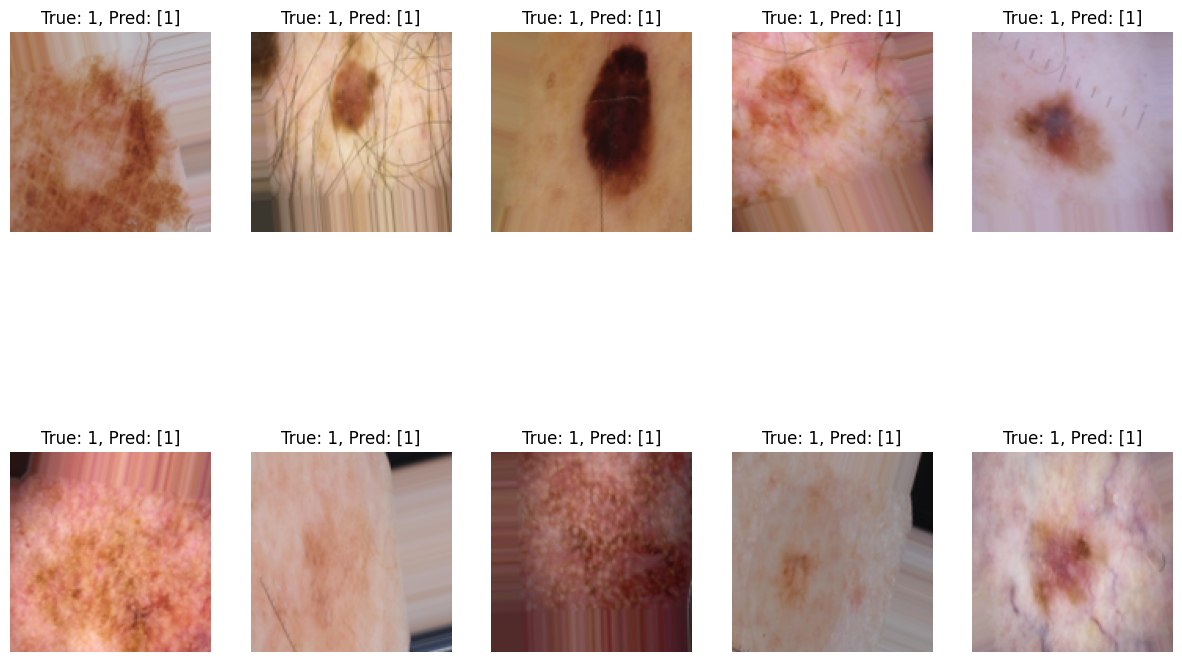

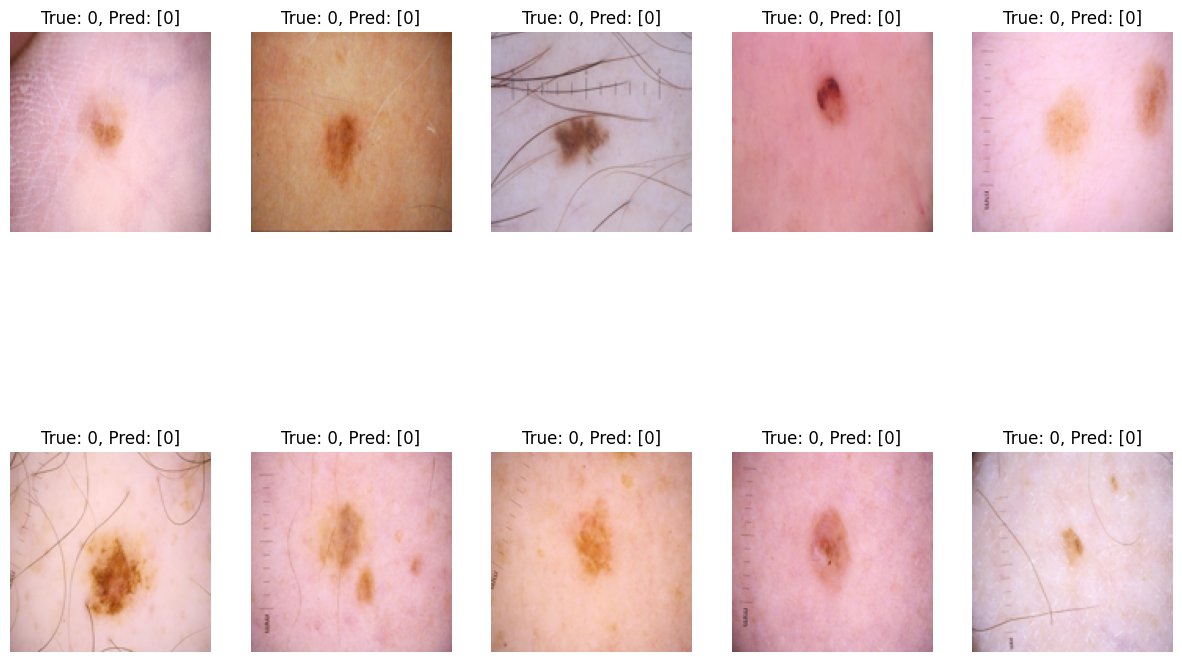

In [6]:
# Beispielbilder anzeigen
def plot_predictions(images, targets, predictions, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {targets[i]}, Pred: {predictions[i]}")
        plt.axis('off')
        
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(images[-(i+1)])
        plt.title(f"True: {targets[-(i+1)]}, Pred: {predictions[-(i+1)]}")
        plt.axis('off')
    
    plt.show()

# Beispielbilder von Positiv und Negativ anzeigen
melanoma_indices = np.where(val_targets_balanced == 1)[0]
non_melanoma_indices = np.where(val_targets_balanced == 0)[0]

# Sicherstellen, dass die Indizes nicht außerhalb des Bereichs liegen
melanoma_indices = melanoma_indices[melanoma_indices < len(val_images_balanced)]
non_melanoma_indices = non_melanoma_indices[non_melanoma_indices < len(val_images_balanced)]

plot_predictions(val_images_balanced[melanoma_indices], val_targets_balanced[melanoma_indices], val_predictions[melanoma_indices])
plot_predictions(val_images_balanced[non_melanoma_indices], val_targets_balanced[non_melanoma_indices], val_predictions[non_melanoma_indices])

# Model speichern

In [7]:
model.save("/kaggle/working/modelfunktioniert.h5")
datetime.datetime.now().strftime("Fertiggestellt um %X den %x")

'Fertiggestellt um 08:38:13 den 06/12/24'

In [8]:
import gc

del train_images
del train_targets
del val_images
del val_targets

gc.collect()

52995

# Visualisierung der Ergebnisse

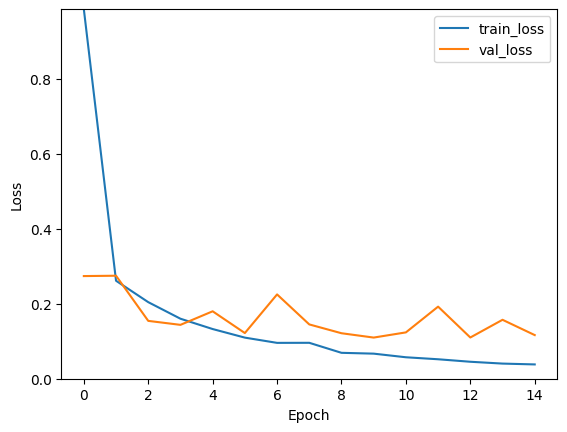

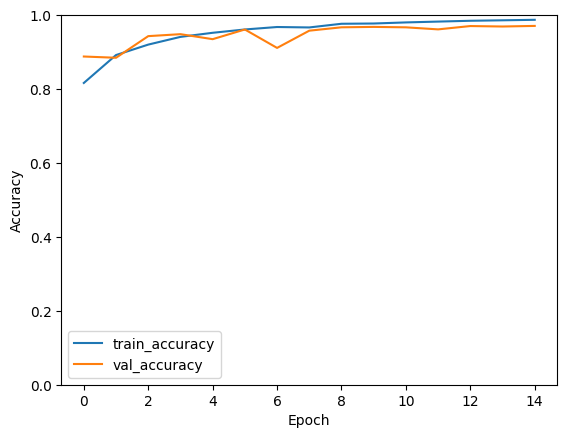

In [9]:
# Visualisierung der Trainings- und Validierungsverluste
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, max(history.history['loss'] + history.history['val_loss']))  # Setze die y-Achsenbegrenzung von 0 bis zum maximalen Verlustwert
plt.legend()
plt.show()

# Visualisierung der Trainings- und Validierungsgenauigkeit
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Setze die y-Achsenbegrenzung von 0 bis 1 für die Genauigkeit
plt.legend()
plt.show()

## Die Konfusionsmatrix zeigt hohe Werte in TP und TN an, was bedeutet, dass das Modell richtig funktioniert

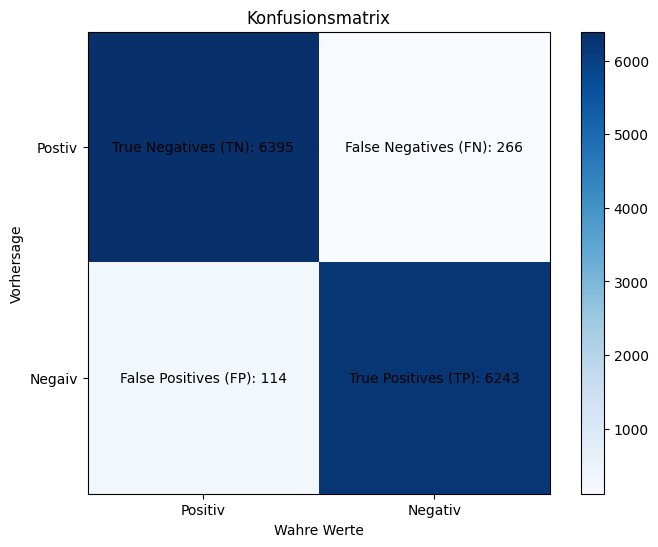

In [10]:

conf_matrix = confusion_matrix(val_targets_balanced, val_predictions)

# Berechnung von TP, TN, FP und FN
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Plot der Confusion Matrix mit Werten
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.title('Konfusionsmatrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Positiv', 'Negativ'])
plt.yticks(tick_marks, ['Postiv', 'Negaiv'])
plt.xlabel('Wahre Werte')
plt.ylabel('Vorhersage')

# Anzeigen von TP, TN, FP und FN
plt.text(0, 0, f"True Negatives (TN): {TN}", horizontalalignment='center', verticalalignment='center', color='black')
plt.text(1, 1, f"True Positives (TP): {TP}", horizontalalignment='center', verticalalignment='center', color='black')
plt.text(0, 1, f"False Positives (FP): {FP}", horizontalalignment='center', verticalalignment='center', color='black')
plt.text(1, 0, f"False Negatives (FN): {FN}", horizontalalignment='center', verticalalignment='center', color='black')

plt.show()

# Vorhersagen auf den Testbildern
test_predictions = (model.predict(test_images) > 0.5).astype("int32")

# Entfernen der ".jpg"-Erweiterung von den Bildnamen
test_image_names = [os.path.splitext(name)[0] for name in test_image_names]

# Ergebnisse in eine DataFrame speichern
results = pd.DataFrame({'image_name': test_image_names, 'target': test_predictions.flatten()})

# Speichern der Ergebnisse in eine CSV-Datei
output_path = '/kaggle/working/submission.csv'
results.to_csv(output_path, index=False)

datetime.datetime.now().strftime("Fertiggestellt um %X den %x")# Vorbereitung für die Submission in Kaggle
Die Testbilder werden geladen, die Namen aus den Bildpfaden extrahiert und in einer Datei submission.csv unter image_name mit den entsprechenden Targets des Modells gespeichert.

| image_name | target |
| ----------- | ----------- |
|ISIC_XXXXXXX|0|
|ISIC_XXXXXXX|0|
|ISIC_XXXXXXX|1|
|ISIC_XXXXXXX|0|
|ISIC_XXXXXXX|0|

In [11]:
path_image_test = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test'
# path_model = '/kaggle/input/model1/tensorflow1/model_abgabe_97_prozent/1/modelfunktioniert.h5' # Vorerstelltes Modell
path_model = '/kaggle/working/modelfunktioniert.h5' # Neuerstelltes Modell, für submission

# Funktion zum Laden von Bildern
def load_image(image_path, target_size=(128, 128)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    return np.array(image)

# Modell laden
model = load_model(path_model)

# Testbilder laden
def load_test_images(image_dir, target_size=(128, 128), num_workers=None):
    image_names = os.listdir(image_dir)
    images = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        for image_name in image_names:
            image_path = os.path.join(image_dir, image_name)
            futures.append(executor.submit(load_image, image_path, target_size))

        for future in tqdm(futures, desc="Lade Testbilder", total=len(futures)):
            images.append(future.result())

    return np.array(images), image_names

# Anzahl der Prozesse oder Threads einstellen
num_workers = os.cpu_count() or 1   # Alle verfügbaren Kerne, die das System erkennt, ansonsten 1

# Laden der Testbilder
test_images, test_image_names = load_test_images(path_image_test, num_workers=num_workers)

datetime.datetime.now().strftime("Fertiggestellt um %X den %x")

Lade Testbilder: 100%|██████████| 10982/10982 [11:30<00:00, 15.89it/s]


'Fertiggestellt um 08:50:06 den 06/12/24'

In [12]:
# Vorhersagen auf den Testbildern
test_predictions = (model.predict(test_images) > 0.5).astype("int32")

# Entfernen der ".jpg"-Erweiterung von den Bildnamen
test_image_names = [os.path.splitext(name)[0] for name in test_image_names]

# Ergebnisse in eine DataFrame speichern
results = pd.DataFrame({'image_name': test_image_names, 'target': test_predictions.flatten()})

# Speichern der Ergebnisse in eine CSV-Datei
output_path = '/kaggle/working/submission.csv'
results.to_csv(output_path, index=False)

datetime.datetime.now().strftime("Fertiggestellt um %X den %x")

344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


'Fertiggestellt um 08:50:13 den 06/12/24'

In [13]:
# Lesen der CSV-Datei
submission_df = pd.read_csv(output_path)

# Überprüfen, ob die Datei korrekt eingelesen wurde
print(submission_df.head())

# Zählen der Anzahl von 0 und 1 in der 'prediction' Spalte
counts = submission_df['target'].value_counts()

# Ausgabe der Ergebnisse
print(f"Anzahl der 0 in den Vorhersagen: {counts.get(0, 0)}")
print(f"Anzahl der 1 in den Vorhersagen: {counts.get(1, 1)}")

     image_name  target
0  ISIC_2417927       0
1  ISIC_0546632       0
2  ISIC_2227618       0
3  ISIC_7969975       0
4  ISIC_3356592       0
Anzahl der 0 in den Vorhersagen: 9751
Anzahl der 1 in den Vorhersagen: 1231
